# torch

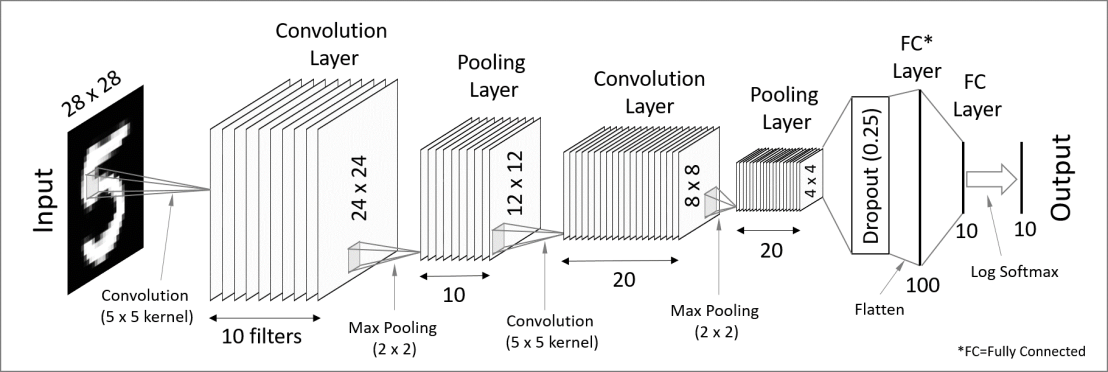

## 신경망 클래스 선언

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


## 임의의 입력값

In [3]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0517,  0.0947,  0.0003, -0.1299, -0.0803,  0.0751, -0.0258,  0.0692,
          0.0351, -0.0091]], grad_fn=<AddmmBackward0>)


## 역전파

In [4]:
net.zero_grad()
out.backward(torch.randn(1, 10))

## 손실 함수(Loss Function)

In [5]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.7412, grad_fn=<MseLossBackward0>)


## 역전파

In [6]:
# 역전파 전과 후의 conv1의 bias gradient

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

#loss.backward() 호출
loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0053,  0.0007, -0.0004,  0.0039, -0.0086,  0.0054])


## 가중치 갱신

In [7]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [8]:
import torch.optim as optim

# Optimizer를 생성합니다.
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 학습 과정(training loop)에서는 다음과 같습니다:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# 이미지 분류기(Classifier) 학습하기

CIFAR10 데이터셋 특성
카테고리 : ‘비행기(airplane)’, ‘자동차(automobile)’, ‘새(bird)’, ‘고양이(cat)’, ‘사슴(deer)’, ‘개(dog)’, ‘개구리(frog)’, ‘말(horse)’, ‘배(ship)’, ‘트럭(truck)’
이미지의 크기 : 3x32x32 (32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 뜻)

## CIFAR10를 불러오고 정규화하기

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Files already downloaded and verified


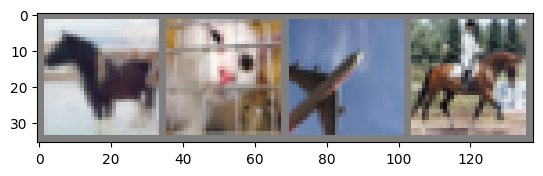

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Use the built-in next function

# Show images
imshow(torchvision.utils.make_grid(images))

In [12]:
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# bird  ship  frog horse

horse   cat plane horse


## 합성곱 신경망 적용하기

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 손실 함수와 Optimizer 정의하기

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 신경망 학습하기

In [15]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.857
[1,  6000] loss: 1.671
[1,  8000] loss: 1.580
[1, 10000] loss: 1.552
[1, 12000] loss: 1.477
[2,  2000] loss: 1.415
[2,  4000] loss: 1.379
[2,  6000] loss: 1.354
[2,  8000] loss: 1.359
[2, 10000] loss: 1.311
[2, 12000] loss: 1.303
Finished Training



## 모델 저장하기

In [16]:
#모델 저장하기
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 시험용 데이터로 신경망 검사하기

Files already downloaded and verified


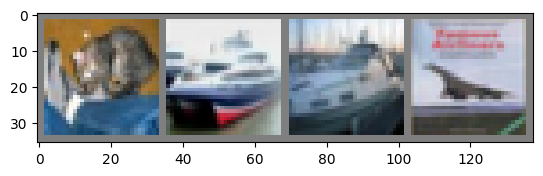

GroundTruth:    cat  ship  ship plane


In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)  # Use the built-in next function

# Show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 모델 불러오기

In [19]:
net = Net()
net.load_state_dict(torch.load(PATH)) #위에서 정의한 PATH

<All keys matched successfully>

In [20]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
#Predicted:    cat   car   car plane

Predicted:   frog  ship  ship  ship


## 정확도

In [21]:
#전체 데이터 셋을 적용한 정확도 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


어떤 것을 잘 분류하고, 어떤 것을 더 못했는지

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 45 %
Accuracy of   car : 64 %
Accuracy of  bird : 21 %
Accuracy of   cat : 21 %
Accuracy of  deer : 52 %
Accuracy of   dog : 58 %
Accuracy of  frog : 78 %
Accuracy of horse : 60 %
Accuracy of  ship : 70 %
Accuracy of truck : 52 %


# GPU에서 학습하기

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#cuda:0

cpu


In [24]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
inputs, labels = data[0].to(device), data[1].to(device)

#  MNIST 문자인식 구현 예제

## 파이토치(PyTorch)를 사용한 MNIST 문자인식 구현 예제

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transfroms
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device + " is available")
 
learning_rate = 0.001
batch_size = 100
num_classes = 10
epochs = 5
 
# MNIST 데이터셋 로드
train_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transfroms.Compose([
        transfroms.ToTensor() # 데이터를 0에서 255까지 있는 값을 0에서 1사이 값으로 변환
    ])
)
test_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transfroms.Compose([
        transfroms.ToTensor() # 데이터를 0에서 255까지 있는 값을 0에서 1사이 값으로 변환
    ])
)
 
# train_loader, test_loader 생성
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
 
# input size를 알기 위해서
examples = enumerate(train_set)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape
 
class ConvNet(nn.Module):
  def __init__(self): # layer 정의
        super(ConvNet, self).__init__()

        # input size = 28x28 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # input channel = 1, filter = 10, kernel size = 5, zero padding = 0, stribe = 1
        # ((W-K+2P)/S)+1 공식으로 인해 ((28-5+0)/1)+1=24 -> 24x24로 변환
        # maxpooling하면 12x12
  
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # input channel = 1, filter = 10, kernel size = 5, zero padding = 0, stribe = 1
        # ((12-5+0)/1)+1=8 -> 8x8로 변환
        # maxpooling하면 4x4

        self.drop2D = nn.Dropout2d(p=0.25, inplace=False) # 랜덤하게 뉴런을 종료해서 학습을 방해해 학습이 학습용 데이터에 치우치는 현상을 막기 위해 사용
        self.mp = nn.MaxPool2d(2)  # 오버피팅을 방지하고, 연산에 들어가는 자원을 줄이기 위해 maxpolling
        self.fc1 = nn.Linear(320,100) # 4x4x20 vector로 flat한 것을 100개의 출력으로 변경
        self.fc2 = nn.Linear(100,10) # 100개의 출력을 10개의 출력으로 변경

  def forward(self, x):
        x = F.relu(self.mp(self.conv1(x))) # convolution layer 1번에 relu를 씌우고 maxpool, 결과값은 12x12x10
        x = F.relu(self.mp(self.conv2(x))) # convolution layer 2번에 relu를 씌우고 maxpool, 결과값은 4x4x20
        x = self.drop2D(x)
        x = x.view(x.size(0), -1) # flat
        x = self.fc1(x) # fc1 레이어에 삽입
        x = self.fc2(x) # fc2 레이어에 삽입
        return F.log_softmax(x) # fully-connected layer에 넣고 logsoftmax 적용
 
model = ConvNet().to(device) # CNN instance 생성
# Cost Function과 Optimizer 선택
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
 
for epoch in range(epochs): # epochs수만큼 반복
    avg_cost = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() # 모든 model의 gradient 값을 0으로 설정
        hypothesis = model(data) # 모델을 forward pass해 결과값 저장 
        cost = criterion(hypothesis, target) # output과 target의 loss 계산
        cost.backward() # backward 함수를 호출해 gradient 계산
        optimizer.step() # 모델의 학습 파라미터 갱신
        avg_cost += cost / len(train_loader) # loss 값을 변수에 누적하고 train_loader의 개수로 나눔 = 평균
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
 
# test
model.eval() # evaluate mode로 전환 dropout 이나 batch_normalization 해제 
with torch.no_grad(): # grad 해제 
    correct = 0
    total = 0

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        out = model(data)
        preds = torch.max(out.data, 1)[1] # 출력이 분류 각각에 대한 값으로 나타나기 때문에, 가장 높은 값을 갖는 인덱스를 추출
        total += len(target) # 전체 클래스 개수 
        correct += (preds==target).sum().item() # 예측값과 실제값이 같은지 비교
        
    print('Test Accuracy: ', 100.*correct/total, '%')


cpu is available
Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw



C:\Users\k8s\AppData\Local\Temp\ipykernel_7524\2714754914.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # fully-connected layer에 넣고 logsoftmax 적용


[Epoch:    1] cost = 0.317341655
[Epoch:    2] cost = 0.114628896
[Epoch:    3] cost = 0.0867306069
[Epoch:    4] cost = 0.0749817565
[Epoch:    5] cost = 0.0666646436
Test Accuracy:  98.54 %


# Transfer Learning

In [30]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

## 데이터 불러오기
개미와 벌 분류 문제-https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [32]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\DEV\miniconda3\envs\pytorch38\lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 모델 학습하기

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

## 일부 이미지 예측값을 보여주는 함수

In [34]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 합성곱 신경망 미세조정(finetuning)

In [35]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.(개미, 벌)
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\DEV\miniconda3\envs\pytorch38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\DEV\miniconda3\envs\pytorch38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\k8s/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [36]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6302 Acc: 0.6639
val Loss: 0.3170 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4883 Acc: 0.7787
val Loss: 0.4015 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.4925 Acc: 0.8115
val Loss: 0.2968 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4395 Acc: 0.8238
val Loss: 0.2484 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.5990 Acc: 0.7869
val Loss: 0.4153 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.6117 Acc: 0.7828
val Loss: 0.4190 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.5096 Acc: 0.8074
val Loss: 0.3381 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4558 Acc: 0.7992
val Loss: 0.2462 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3754 Acc: 0.8402
val Loss: 0.2264 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2524 Acc: 0.8934
val Loss: 0.2116 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2073 Acc: 0.9139
val Loss: 0.2214 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2963 Acc: 0.8525
val Loss: 0.2329 Acc: 0.9150

Ep

## 예측 결과 일부 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


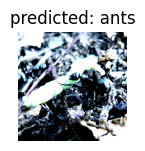

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


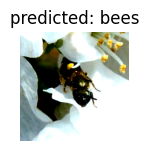

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


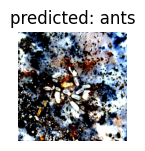

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


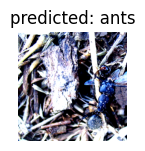

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


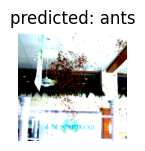

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


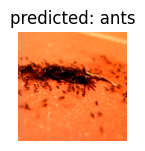

In [37]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망

In [38]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [39]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5370 Acc: 0.7090
val Loss: 0.2265 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4901 Acc: 0.7746
val Loss: 0.2915 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.3556 Acc: 0.8484
val Loss: 0.1697 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.6298 Acc: 0.7213
val Loss: 0.3542 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5294 Acc: 0.7951
val Loss: 0.1703 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5053 Acc: 0.7910
val Loss: 0.1625 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5538 Acc: 0.7582
val Loss: 0.1567 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.2735 Acc: 0.8852
val Loss: 0.1420 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.2795 Acc: 0.8811
val Loss: 0.1510 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3981 Acc: 0.8197
val Loss: 0.1540 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3510 Acc: 0.8279
val Loss: 0.1488 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3756 Acc: 0.8279
val Loss: 0.1513 Acc: 0.9608

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


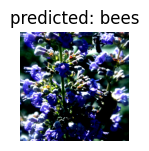

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


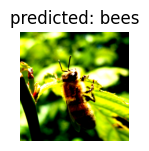

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


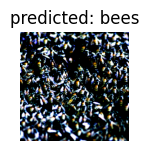

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


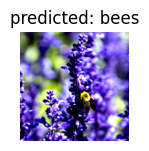

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


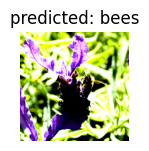

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


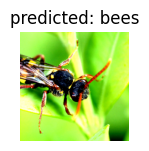

In [40]:
visualize_model(model_conv)

plt.ioff()
plt.show()